In [1]:
import os
import re

import matplotlib.pyplot as plot
import numpy as np
import pandas as pd
import torch
from gensim.models import Word2Vec
from gensim.parsing import remove_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier

d:\python\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
from sklearn.svm import SVC
from torchtext import vocab

columns = ["ProductName", "level_1", "level_2", "level_3", "PricePerItem", "PriceMode", "HasMultiBuyDeal",
           "MultiBuyDeal", "MultiBuyBasePrice", "MultiBuyPrice", "MultiBuyQuantity", "PromoBadgeImageLabel"]
df = pd.read_csv("data.csv", usecols=columns)
df.drop_duplicates(inplace=True)
df.head(5)

,ProductName,level_1,level_2,level_3,PricePerItem,PriceMode,HasMultiBuyDeal,MultiBuyDeal,MultiBuyBasePrice,MultiBuyPrice,MultiBuyQuantity,PromoBadgeImageLabel
0,Johnson's Baby Lotion,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,NaN,4.89,NaN,NaN,NaN
1,Johnson's Baby Oil,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,NaN,4.89,NaN,NaN,NaN
2,SMA Balanced Nutrition From Birth Infant Formula,"Baby, Toddler & Kids",Baby Care,Baby Formula & Toddler Food,17.99,ea,False,NaN,17.99,17.99,1.0,Saver
3,Johnson's Baby Powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,2.99,ea,False,NaN,2.99,2.99,1.0,Saver
4,Johnson's Baby Powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,4.89,ea,False,NaN,4.89,NaN,NaN,NaN


In [3]:
punctuations = re.compile(r'[^a-zA-Z\s]+')
df["ProductName"] = [" ".join(punctuations.sub('', x).lower().split()) for x in df["ProductName"].tolist()]
df.head(5)

,ProductName,level_1,level_2,level_3,PricePerItem,PriceMode,HasMultiBuyDeal,MultiBuyDeal,MultiBuyBasePrice,MultiBuyPrice,MultiBuyQuantity,PromoBadgeImageLabel
0,johnsons baby lotion,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,NaN,4.89,NaN,NaN,NaN
1,johnsons baby oil,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,NaN,4.89,NaN,NaN,NaN
2,sma balanced nutrition from birth infant formula,"Baby, Toddler & Kids",Baby Care,Baby Formula & Toddler Food,17.99,ea,False,NaN,17.99,17.99,1.0,Saver
3,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,2.99,ea,False,NaN,2.99,2.99,1.0,Saver
4,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,4.89,ea,False,NaN,4.89,NaN,NaN,NaN


In [4]:
df["MultiBuyDeal"] = [" ".join(punctuations.sub('', y).lower().split()) if y == y else " " for y in
                      df["MultiBuyDeal"].tolist()]
df.head(5)

,ProductName,level_1,level_2,level_3,PricePerItem,PriceMode,HasMultiBuyDeal,MultiBuyDeal,MultiBuyBasePrice,MultiBuyPrice,MultiBuyQuantity,PromoBadgeImageLabel
0,johnsons baby lotion,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,,4.89,NaN,NaN,NaN
1,johnsons baby oil,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,,4.89,NaN,NaN,NaN
2,sma balanced nutrition from birth infant formula,"Baby, Toddler & Kids",Baby Care,Baby Formula & Toddler Food,17.99,ea,False,,17.99,17.99,1.0,Saver
3,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,2.99,ea,False,,2.99,2.99,1.0,Saver
4,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,4.89,ea,False,,4.89,NaN,NaN,NaN


In [5]:
df["PromoBadgeImageLabel"] = [" ".join(punctuations.sub('', z).lower().split()) if z == z else " " for z in
                              df["PromoBadgeImageLabel"].tolist()]
df.head(5)

,ProductName,level_1,level_2,level_3,PricePerItem,PriceMode,HasMultiBuyDeal,MultiBuyDeal,MultiBuyBasePrice,MultiBuyPrice,MultiBuyQuantity,PromoBadgeImageLabel
0,johnsons baby lotion,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,,4.89,NaN,NaN,
1,johnsons baby oil,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,,4.89,NaN,NaN,
2,sma balanced nutrition from birth infant formula,"Baby, Toddler & Kids",Baby Care,Baby Formula & Toddler Food,17.99,ea,False,,17.99,17.99,1.0,saver
3,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,2.99,ea,False,,2.99,2.99,1.0,saver
4,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,4.89,ea,False,,4.89,NaN,NaN,


In [6]:
df["MultiBuyPrice"].fillna(0, inplace=True)
df["MultiBuyQuantity"].fillna(0, inplace=True)
df.head(5)

,ProductName,level_1,level_2,level_3,PricePerItem,PriceMode,HasMultiBuyDeal,MultiBuyDeal,MultiBuyBasePrice,MultiBuyPrice,MultiBuyQuantity,PromoBadgeImageLabel
0,johnsons baby lotion,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,,4.89,0.00,0.0,
1,johnsons baby oil,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,,4.89,0.00,0.0,
2,sma balanced nutrition from birth infant formula,"Baby, Toddler & Kids",Baby Care,Baby Formula & Toddler Food,17.99,ea,False,,17.99,17.99,1.0,saver
3,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,2.99,ea,False,,2.99,2.99,1.0,saver
4,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,4.89,ea,False,,4.89,0.00,0.0,


<BarContainer object of 449 artists>

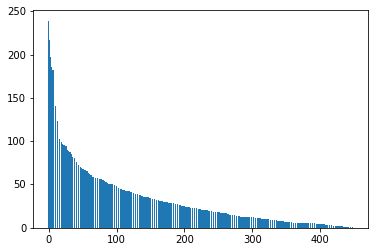

In [7]:
typesa = df.value_counts(columns[1:4])
plot.bar([a for a in range(typesa.size)], typesa)

<BarContainer object of 43 artists>

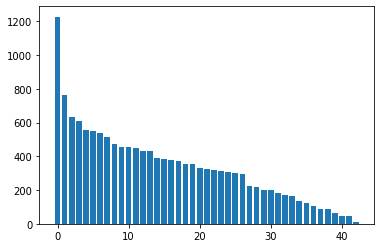

In [8]:
typesb = df.value_counts(columns[1:3])
plot.bar([a for a in range(typesb.size)], typesb)

In [9]:
typesc = df.value_counts(columns[1:2])
typesc

level_1                    
Pantry                         4740
Personal Care                  1778
Fresh Foods & Bakery           1721
Chilled, Frozen & Desserts     1426
Beer, Cider & Wine             1232
Kitchen, Dining & Household    1182
Drinks                         1063
Pets                            512
Meal Spot                       456
Baby, Toddler & Kids            354
Featured                        121
dtype: int64

In [10]:
df = df[df["level_1"] != "Featured"]
df = df[df["level_1"] != "Meal Spot"]
df.head(5)

,ProductName,level_1,level_2,level_3,PricePerItem,PriceMode,HasMultiBuyDeal,MultiBuyDeal,MultiBuyBasePrice,MultiBuyPrice,MultiBuyQuantity,PromoBadgeImageLabel
0,johnsons baby lotion,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,,4.89,0.00,0.0,
1,johnsons baby oil,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,,4.89,0.00,0.0,
2,sma balanced nutrition from birth infant formula,"Baby, Toddler & Kids",Baby Care,Baby Formula & Toddler Food,17.99,ea,False,,17.99,17.99,1.0,saver
3,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,2.99,ea,False,,2.99,2.99,1.0,saver
4,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,4.89,ea,False,,4.89,0.00,0.0,


(array([1.856e+03, 4.425e+03, 3.087e+03, 1.348e+03, 9.700e+02, 5.280e+02,
        5.470e+02, 1.880e+02, 2.160e+02, 1.670e+02, 1.250e+02, 7.600e+01,
        2.800e+01, 2.000e+01, 2.800e+01, 1.200e+01, 2.200e+01, 6.000e+00,
        1.200e+01, 1.000e+00, 1.200e+01, 0.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  0.15  ,   2.5668,   4.9836,   7.4004,   9.8172,  12.234 ,
         14.6508,  17.0676,  19.4844,  21.9012,  24.318 ,  26.7348,
         29.1516,  31.5684,  33.9852,  36.402 ,  38.8188,  41.2356,
         43.6524,  46.0692,  48.486 ,  50.9028,  53.3196,  55.7364,
         58.1532,  60.57  ,  62.9868,  65.4036,  67.8204,  70.2372,
         72.654 ,  75.0708,  77.4876

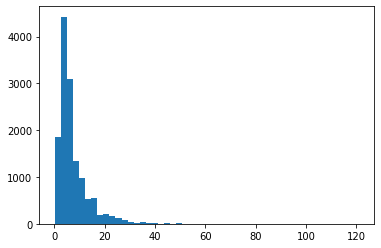

In [11]:
dfea = df[df["PriceMode"] == "ea"]
plot.hist(dfea["PricePerItem"].tolist(), bins=50)

(array([13., 21., 22., 13., 21., 29., 30.,  9., 37., 19., 39.,  9.,  9.,
        14.,  9.,  1.,  3.,  3.,  7.,  2.,  2.,  1.,  0.,  1.,  0.,  0.,
         1.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  2.29  ,   4.8422,   7.3944,   9.9466,  12.4988,  15.051 ,
         17.6032,  20.1554,  22.7076,  25.2598,  27.812 ,  30.3642,
         32.9164,  35.4686,  38.0208,  40.573 ,  43.1252,  45.6774,
         48.2296,  50.7818,  53.334 ,  55.8862,  58.4384,  60.9906,
         63.5428,  66.095 ,  68.6472,  71.1994,  73.7516,  76.3038,
         78.856 ,  81.4082,  83.9604,  86.5126,  89.0648,  91.617 ,
         94.1692,  96.7214,  99.2736, 101.8258, 104.378 , 106.9302,
        109.4824, 112.0346, 114.5868, 117.139 , 119.6912, 122.2434,
        124.7956, 127.3478, 129.9   ]),
 <BarContainer object of 50 artists>)

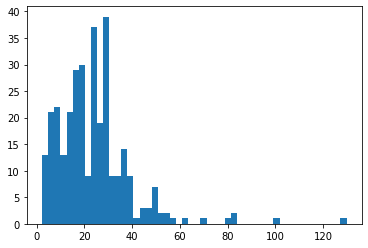

In [12]:
dfkg = df[df["PriceMode"] == "kg"]
plot.hist(dfkg["PricePerItem"].tolist(), bins=50)

In [13]:
df["PricePerItem"] = [round(p / 5) * 5 for p in df["PricePerItem"].tolist()]
df["MultiBuyPrice"] = [round(p / 5) * 5 for p in df["MultiBuyPrice"].tolist()]
df["MultiBuyBasePrice"] = [round(p / 5) * 5 for p in df["MultiBuyBasePrice"].tolist()]
df["MultiBuyQuantity"] = [int(q) for q in df["MultiBuyQuantity"].tolist()]
df.head(5)

,ProductName,level_1,level_2,level_3,PricePerItem,PriceMode,HasMultiBuyDeal,MultiBuyDeal,MultiBuyBasePrice,MultiBuyPrice,MultiBuyQuantity,PromoBadgeImageLabel
0,johnsons baby lotion,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,5,ea,False,,5,0,0,
1,johnsons baby oil,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,5,ea,False,,5,0,0,
2,sma balanced nutrition from birth infant formula,"Baby, Toddler & Kids",Baby Care,Baby Formula & Toddler Food,20,ea,False,,20,20,1,saver
3,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,5,ea,False,,5,5,1,saver
4,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,5,ea,False,,5,0,0,


In [14]:
levela = df["level_1"].tolist()
levelb = df["level_2"].tolist()
two = [";".join([levela[i], levelb[i]]) for i in range(len(levela))]
one = levela

In [15]:
texts = df["ProductName"].tolist()
vectorizer = TfidfVectorizer(stop_words='english')
features = vectorizer.fit_transform(texts)

In [16]:
label2idtwo = {l: i for i, l in enumerate(set(two))}
id2labeltwo = {i: l for l, i in label2idtwo.items()}
two = [label2idtwo[l] for l in two]
label2idone = {l: i for i, l in enumerate(set(one))}
id2labelone = {i: l for l, i in label2idone.items()}
one = [label2idone[l] for l in one]
x_traint, x_testt, y_traint, y_testt = train_test_split(features, two, test_size=0.25, random_state=3)
x_traino, x_testo, y_traino, y_testo = train_test_split(features, one, test_size=0.25, random_state=3)

In [17]:
model = LogisticRegression(max_iter=500)
model.fit(x_traint, y_traint)
predict_labelst = model.predict(x_testt)
predict_labelst = [np.round(p) for p in predict_labelst]
max_labelt = len(id2labeltwo) - 1
predict_labelst = [l if max_labelt >= l else max_labelt for l in predict_labelst]
min_label = 0
predict_labelst = [l if min_label <= l else min_label for l in predict_labelst]
print(classification_report(y_testt, predict_labelst, target_names=[id2labeltwo[i] for i in range(len(id2labeltwo))]))

                                                        precision    recall  f1-score   support

                               Beer, Cider & Wine;Wine       0.99      0.98      0.98       167
               Chilled, Frozen & Desserts;Frozen Foods       0.80      0.80      0.80       128
          Kitchen, Dining & Household;Garage & Outdoor       1.00      0.08      0.14        13
                                    Pantry;World Foods       0.87      0.55      0.67        49
                       Personal Care;Health & Wellness       0.93      0.87      0.90       158
                       Personal Care;Beauty & Grooming       0.76      1.00      0.86       282
               Fresh Foods & Bakery;Fruit & Vegetables       1.00      0.69      0.82        49
                                     Pets;Pet Supplies       1.00      0.97      0.99       141
                                     Drinks;Hot Drinks       0.18      0.18      0.18        94
                        Baby, Toddler &

d:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
model = LogisticRegression(max_iter=500)
model.fit(x_traino, y_traino)
predict_labelso = model.predict(x_testo)
predict_labelso = [np.round(p) for p in predict_labelso]
max_labelo = len(id2labelone) - 1
predict_labelso = [l if max_labelo >= l else max_labelo for l in predict_labelso]
min_label = 0
predict_labelso = [l if min_label <= l else min_label for l in predict_labelso]
print(classification_report(y_testo, predict_labelso, target_names=[id2labelone[i] for i in range(len(id2labelone))]))

                             precision    recall  f1-score   support

       Baby, Toddler & Kids       0.99      0.81      0.89        93
         Beer, Cider & Wine       0.99      0.92      0.96       301
                     Pantry       0.80      0.93      0.86      1191
              Personal Care       0.96      0.93      0.95       440
Kitchen, Dining & Household       0.97      0.89      0.93       263
 Chilled, Frozen & Desserts       0.69      0.63      0.66       368
       Fresh Foods & Bakery       0.79      0.68      0.73       456
                       Pets       1.00      0.91      0.96       141
                     Drinks       0.70      0.65      0.67       249

                   accuracy                           0.84      3502
                  macro avg       0.88      0.82      0.84      3502
               weighted avg       0.84      0.84      0.84      3502



In [19]:
k = len(id2labeltwo)
model = KNeighborsClassifier(n_neighbors=k)
model.fit(x_traint, y_traint)
predict_labelst = model.predict(x_testt)
print(classification_report(y_testt, predict_labelst, target_names=[id2labeltwo[i] for i in range(len(id2labeltwo))]))

                                                        precision    recall  f1-score   support

                               Beer, Cider & Wine;Wine       0.90      0.96      0.93       167
               Chilled, Frozen & Desserts;Frozen Foods       0.71      0.56      0.63       128
          Kitchen, Dining & Household;Garage & Outdoor       1.00      0.23      0.38        13
                                    Pantry;World Foods       0.89      0.35      0.50        49
                       Personal Care;Health & Wellness       0.88      0.68      0.76       158
                       Personal Care;Beauty & Grooming       0.86      0.96      0.91       282
               Fresh Foods & Bakery;Fruit & Vegetables       0.91      0.86      0.88        49
                                     Pets;Pet Supplies       0.87      0.95      0.91       141
                                     Drinks;Hot Drinks       0.42      0.59      0.49        94
                        Baby, Toddler &

In [20]:
k = len(id2labelone)
model = KNeighborsClassifier(n_neighbors=k)
model.fit(x_traino, y_traino)
predict_labelso = model.predict(x_testo)
print(classification_report(y_testo, predict_labelso, target_names=[id2labelone[i] for i in range(len(id2labelone))]))

                             precision    recall  f1-score   support

       Baby, Toddler & Kids       0.99      0.91      0.95        93
         Beer, Cider & Wine       0.98      0.96      0.97       301
                     Pantry       0.85      0.91      0.88      1191
              Personal Care       0.97      0.92      0.94       440
Kitchen, Dining & Household       0.96      0.90      0.93       263
 Chilled, Frozen & Desserts       0.66      0.71      0.68       368
       Fresh Foods & Bakery       0.77      0.68      0.72       456
                       Pets       0.99      0.94      0.96       141
                     Drinks       0.68      0.71      0.70       249

                   accuracy                           0.85      3502
                  macro avg       0.87      0.85      0.86      3502
               weighted avg       0.85      0.85      0.85      3502



In [21]:
def knn_cross_validation(x_train, y_train):
    k_list = list(range(1, 30))
    list_scores = []

    for k in k_list:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, x_train, y_train, cv=10, scoring='accuracy')
        list_scores.append(scores.mean())

    MSE = [1 - x for x in list_scores]
    optimal_k = k_list[MSE.index(min(MSE))]
    print("The optimal number of neighbors is %d" % optimal_k)
    plot.plot(k_list, list_scores)
    plot.xlabel('Number of Neighbors K')
    plot.ylabel('correct classification rate')
    plot.show()
    return optimal_k

The optimal number of neighbors is 6


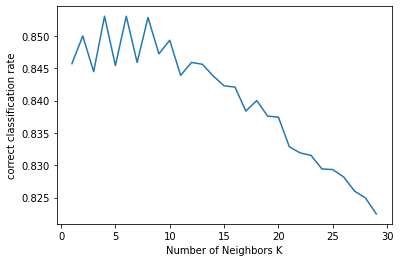

In [22]:
ko = knn_cross_validation(x_traino, y_traino)

d:\python\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
d:\python\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
d:\python\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
d:\python\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
d:\python\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated 

The optimal number of neighbors is 1


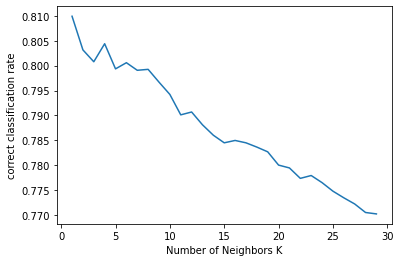

In [23]:
kt = knn_cross_validation(x_traint, y_traint)

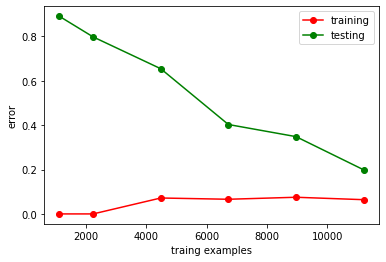

In [24]:
knn = KNeighborsClassifier(n_neighbors=kt)
train_sizes, train_score, test_score = learning_curve(knn, features, two, train_sizes=[0.1, 0.2, 0.4, 0.6, 0.8, 1],
                                                      cv=5, scoring='accuracy')
train_error = 1 - np.mean(train_score, axis=1)
test_error = 1 - np.mean(test_score, axis=1)
plot.plot(train_sizes, train_error, 'o-', color='r', label='training')
plot.plot(train_sizes, test_error, 'o-', color='g', label='testing')
plot.legend(loc='best')
plot.xlabel('traing examples')
plot.ylabel('error')
plot.show()

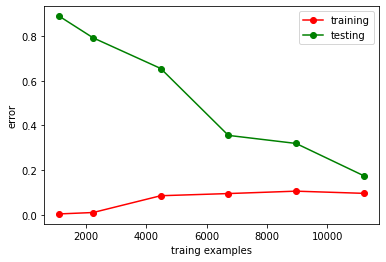

In [25]:
knn = KNeighborsClassifier(n_neighbors=ko)
train_sizes, train_score, test_score = learning_curve(knn, features, one, train_sizes=[0.1, 0.2, 0.4, 0.6, 0.8, 1],
                                                      cv=5, scoring='accuracy')
train_error = 1 - np.mean(train_score, axis=1)
test_error = 1 - np.mean(test_score, axis=1)
plot.plot(train_sizes, train_error, 'o-', color='r', label='training')
plot.plot(train_sizes, test_error, 'o-', color='g', label='testing')
plot.legend(loc='best')
plot.xlabel('traing examples')
plot.ylabel('error')
plot.show()

In [26]:
model = OneVsRestClassifier(SVC())
model.fit(x_traint, y_traint)
svm_predict_labelst = model.predict(x_testt)
print(
    classification_report(y_testt, svm_predict_labelst, target_names=[id2labeltwo[i] for i in range(len(id2labeltwo))]))

                                                        precision    recall  f1-score   support

                               Beer, Cider & Wine;Wine       0.99      0.99      0.99       167
               Chilled, Frozen & Desserts;Frozen Foods       0.89      0.85      0.87       128
          Kitchen, Dining & Household;Garage & Outdoor       1.00      0.62      0.76        13
                                    Pantry;World Foods       0.89      0.63      0.74        49
                       Personal Care;Health & Wellness       0.96      0.93      0.95       158
                       Personal Care;Beauty & Grooming       0.91      0.99      0.95       282
               Fresh Foods & Bakery;Fruit & Vegetables       1.00      0.82      0.90        49
                                     Pets;Pet Supplies       1.00      1.00      1.00       141
                                     Drinks;Hot Drinks       0.14      0.15      0.15        94
                        Baby, Toddler &

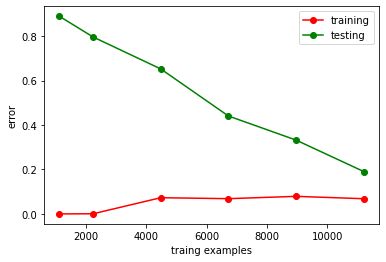

In [27]:
train_sizes, train_score, test_score = learning_curve(SVC(), features, two, train_sizes=[0.1, 0.2, 0.4, 0.6, 0.8, 1],
                                                      cv=5, scoring='accuracy')
train_error = 1 - np.mean(train_score, axis=1)
test_error = 1 - np.mean(test_score, axis=1)
plot.plot(train_sizes, train_error, 'o-', color='r', label='training')
plot.plot(train_sizes, test_error, 'o-', color='g', label='testing')
plot.legend(loc='best')
plot.xlabel('traing examples')
plot.ylabel('error')
plot.show()

In [28]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(x_traint, y_traint)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_truet, y_predt = y_testt, clf.predict(x_testt)
    print(classification_report(y_truet, y_predt))
    print()

# Tuning hyper-parameters for precision



d:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 

Best parameters set found on development set:

{'C': 1, 'kernel': 'linear'}

Grid scores on development set:

0.002 (+/-0.000) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.002 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.054 (+/-0.032) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.002 (+/-0.000) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.774 (+/-0.041) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.054 (+/-0.032) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.856 (+/-0.013) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.773 (+/-0.042) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.860 (+/-0.018) for {'C': 1, 'kernel': 'linear'}
0.851 (+/-0.013) for {'C': 10, 'kernel': 'linear'}
0.849 (+/-0.011) for {'C': 100, 'kernel': 'linear'}
0.849 (+/-0.012) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    

In [29]:
model = OneVsRestClassifier(SVC())
model.fit(x_traino, y_traino)
svm_predict_labelso = model.predict(x_testo)
print(
    classification_report(y_testo, svm_predict_labelso, target_names=[id2labelone[i] for i in range(len(id2labelone))]))

                             precision    recall  f1-score   support

       Baby, Toddler & Kids       1.00      0.89      0.94        93
         Beer, Cider & Wine       1.00      0.97      0.98       301
                     Pantry       0.86      0.92      0.89      1191
              Personal Care       0.97      0.96      0.96       440
Kitchen, Dining & Household       0.98      0.95      0.96       263
 Chilled, Frozen & Desserts       0.68      0.69      0.68       368
       Fresh Foods & Bakery       0.79      0.67      0.73       456
                       Pets       1.00      0.99      0.99       141
                     Drinks       0.65      0.66      0.66       249

                   accuracy                           0.86      3502
                  macro avg       0.88      0.86      0.87      3502
               weighted avg       0.86      0.86      0.86      3502



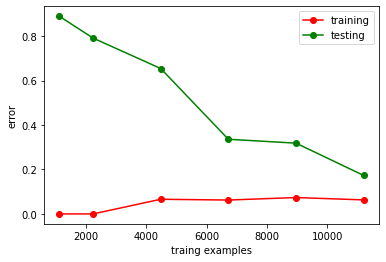

In [30]:
train_sizes, train_score, test_score = learning_curve(SVC(), features, one, train_sizes=[0.1, 0.2, 0.4, 0.6, 0.8, 1],
                                                      cv=5, scoring='accuracy')
train_error = 1 - np.mean(train_score, axis=1)
test_error = 1 - np.mean(test_score, axis=1)
plot.plot(train_sizes, train_error, 'o-', color='r', label='training')
plot.plot(train_sizes, test_error, 'o-', color='g', label='testing')
plot.legend(loc='best')
plot.xlabel('traing examples')
plot.ylabel('error')
plot.show()

In [31]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(x_traino, y_traino)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_trueo, y_predo = y_testo, clf.predict(x_testo)
    print(classification_report(y_trueo, y_predo))
    print()


# Tuning hyper-parameters for precision



d:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 

Best parameters set found on development set:

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.038 (+/-0.000) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.038 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.060 (+/-0.089) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.038 (+/-0.000) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.897 (+/-0.009) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.060 (+/-0.089) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.886 (+/-0.010) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.896 (+/-0.009) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.889 (+/-0.011) for {'C': 1, 'kernel': 'linear'}
0.875 (+/-0.013) for {'C': 10, 'kernel': 'linear'}
0.867 (+/-0.010) for {'C': 100, 'kernel': 'linear'}
0.862 (+/-0.012) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

            

In [32]:
def load_embeddings():
    cache = '.vector_cache'
    if not os.path.exists(cache):
        os.mkdir(cache)
    word2vec = vocab.Vectors(name=r'./word2vec_300dim.txt', cache=cache)
    return word2vec


def encode_text_to_features(vector, text):
    vectors = vector.get_vecs_by_tokens(text.split())
    sentence_vector = torch.mean(vectors, dim=0)
    return sentence_vector.tolist()


sentences = []
map(remove_stopwords, texts)
for i in range(len(texts)):
    sentence = texts[i].split()
    sentence.append(levela[i])
    sentence.append(levelb[i])
    sentences.append(sentence)
w2v = Word2Vec(sentences=sentences, vector_size=300, window=5, min_count=1)
w2v.wv.save_word2vec_format(r'./word2vec_300dim.txt', binary=False)
vector = load_embeddings()
features = [encode_text_to_features(vector, text) for text in texts]

In [33]:
x_traint, x_testt, y_traint, y_testt = train_test_split(features, two, test_size=0.25, random_state=3)
x_traino, x_testo, y_traino, y_testo = train_test_split(features, one, test_size=0.25, random_state=3)

In [34]:
model = LogisticRegression(max_iter=500)
model.fit(x_traint, y_traint)
predict_labelst = model.predict(x_testt)
predict_labelst = [np.round(p) for p in predict_labelst]
max_labelt = len(id2labeltwo) - 1
predict_labelst = [l if max_labelt >= l else max_labelt for l in predict_labelst]
min_label = 0
predict_labelst = [l if min_label <= l else min_label for l in predict_labelst]
print(classification_report(y_testt, predict_labelst, target_names=[id2labeltwo[i] for i in range(len(id2labeltwo))]))

                                                        precision    recall  f1-score   support

                               Beer, Cider & Wine;Wine       0.96      0.77      0.86       167
               Chilled, Frozen & Desserts;Frozen Foods       0.00      0.00      0.00       128
          Kitchen, Dining & Household;Garage & Outdoor       0.00      0.00      0.00        13
                                    Pantry;World Foods       0.00      0.00      0.00        49
                       Personal Care;Health & Wellness       0.00      0.00      0.00       158
                       Personal Care;Beauty & Grooming       0.13      0.92      0.23       282
               Fresh Foods & Bakery;Fruit & Vegetables       0.00      0.00      0.00        49
                                     Pets;Pet Supplies       0.58      0.66      0.62       141
                                     Drinks;Hot Drinks       0.45      0.37      0.41        94
                        Baby, Toddler &

d:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
model = LogisticRegression(max_iter=500)
model.fit(x_traino, y_traino)
predict_labelso = model.predict(x_testo)
predict_labelso = [np.round(p) for p in predict_labelso]
max_labelo = len(id2labelone) - 1
predict_labelso = [l if max_labelo >= l else max_labelo for l in predict_labelso]
min_label = 0
predict_labelst = [l if min_label <= l else min_label for l in predict_labelso]
print(classification_report(y_testo, predict_labelso, target_names=[id2labelone[i] for i in range(len(id2labelone))]))


                             precision    recall  f1-score   support

       Baby, Toddler & Kids       0.00      0.00      0.00        93
         Beer, Cider & Wine       0.99      0.39      0.56       301
                     Pantry       0.40      0.95      0.56      1191
              Personal Care       0.63      0.23      0.34       440
Kitchen, Dining & Household       0.23      0.13      0.17       263
 Chilled, Frozen & Desserts       0.33      0.04      0.06       368
       Fresh Foods & Bakery       0.96      0.05      0.10       456
                       Pets       1.00      0.37      0.54       141
                     Drinks       0.69      0.41      0.52       249

                   accuracy                           0.45      3502
                  macro avg       0.58      0.28      0.32      3502
               weighted avg       0.57      0.45      0.37      3502



d:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
